In [13]:
%load_ext autoreload
%autoreload 2
import numpy as np
from simulation import *
import pickle as pkl
from matplotlib.lines import Line2D
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from itertools import product

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
## Plotting settings
from plotting_utils import *
params, font = plot_context()
context = sns.plotting_context("paper", rc=params)
sns.set_theme(style="whitegrid", font=font)

## Loading experimental runs

In [26]:
settings = ['baseline', 'heterogeneity', 'homogeneity', 'minority_homophily', 'majority_heterophily', 'homo+hetero']       
rec_how  = ['embedding', 'random_fof']
acc_how = ['constant', 'embedding']
intervention_end = [50, 100, 200, 300, 400]
node_removal = [True, False]
edge_removal = [True, False]
p2_mediated = [True, False]

exp_params = list(product(settings, rec_how, acc_how, intervention_end, node_removal, edge_removal, p2_mediated))
longitudinal_exp = defaultdict(list)

for (set, rec, acc, end, node, edge, med) in exp_params:
    with open(f'experiments/longitudinal/{set}_{rec}_{acc}_{end}_{node}_{edge}_{med}.pkl', 'rb') as f:
        rec_how, acc_how, intervention_end, conclusion = pkl.load(f)
        time_range = list(range(50, intervention_end))
        longitudinal_exp[(set, rec, acc, node, edge, med)].append((conclusion, time_range))
        
print(f'There are {len(longitudinal_exp)} longitudinal experiments.')

There are 192 longitudinal experiments.


In [25]:
rec_how  = ['embedding', 'random_fof']
acc_how = ['constant', 'embedding']
intervention_end = [50, 100, 150, 200, 400]
node_removal = [True, False]
edge_removal = [True, False]
p2_mediated = [True, False]
treatment_probability = [0.1, 0.5, 0.9, 'group1']

exp_params = list(product(rec_how, acc_how, intervention_end, node_removal, edge_removal, p2_mediated, treatment_probability))
ab_exp = defaultdict(list)

for (rec, acc, end, node, edge, med, treat) in exp_params:
    with open(f'experiments/ab/{rec}_{acc}_{end}_{node}_{edge}_{med}_{treat}.pkl', 'rb') as f:
        rec_how, acc_how, intervention_end, conclusion = pkl.load(f)
        time_range = list(range(50, intervention_end))
        ab_exp[(rec, acc, node, edge, med, treat)].append((conclusion, time_range))
        
print(f'There are {len(ab_exp)} AB experiments.')

There are 128 AB experiments.


Plot longitudinal metrics

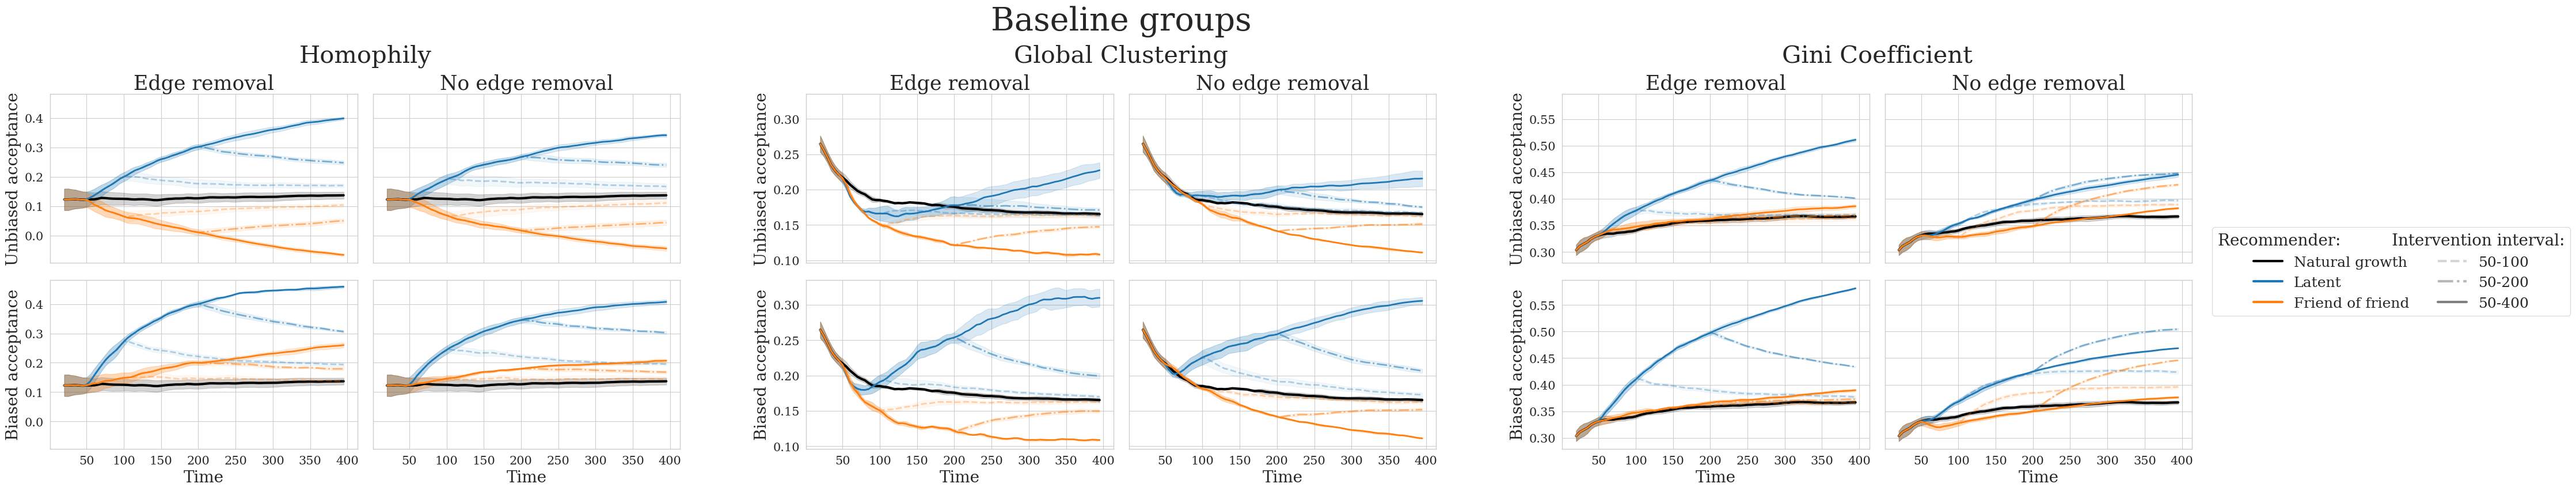

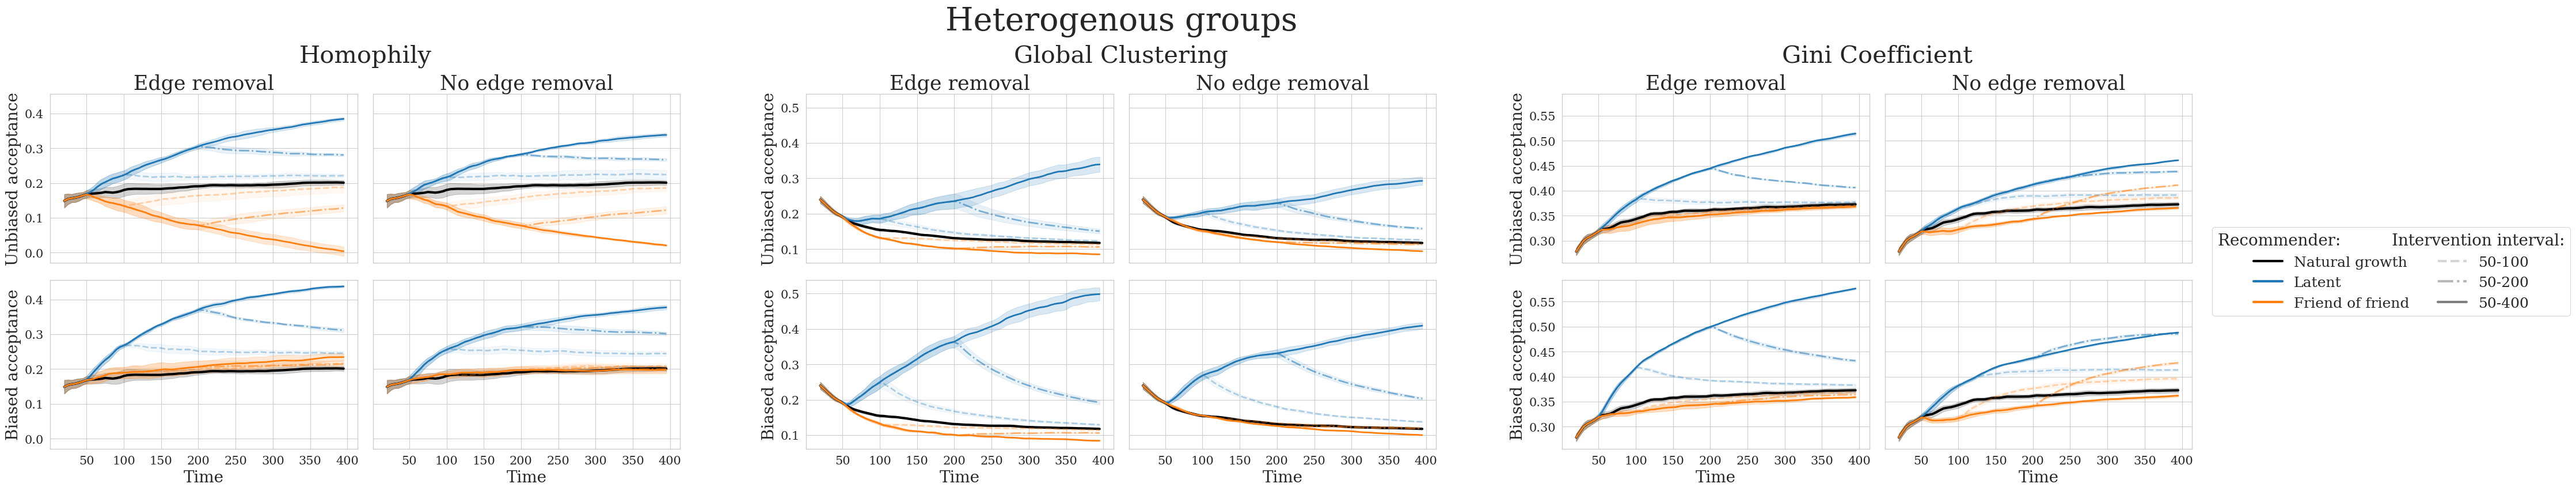

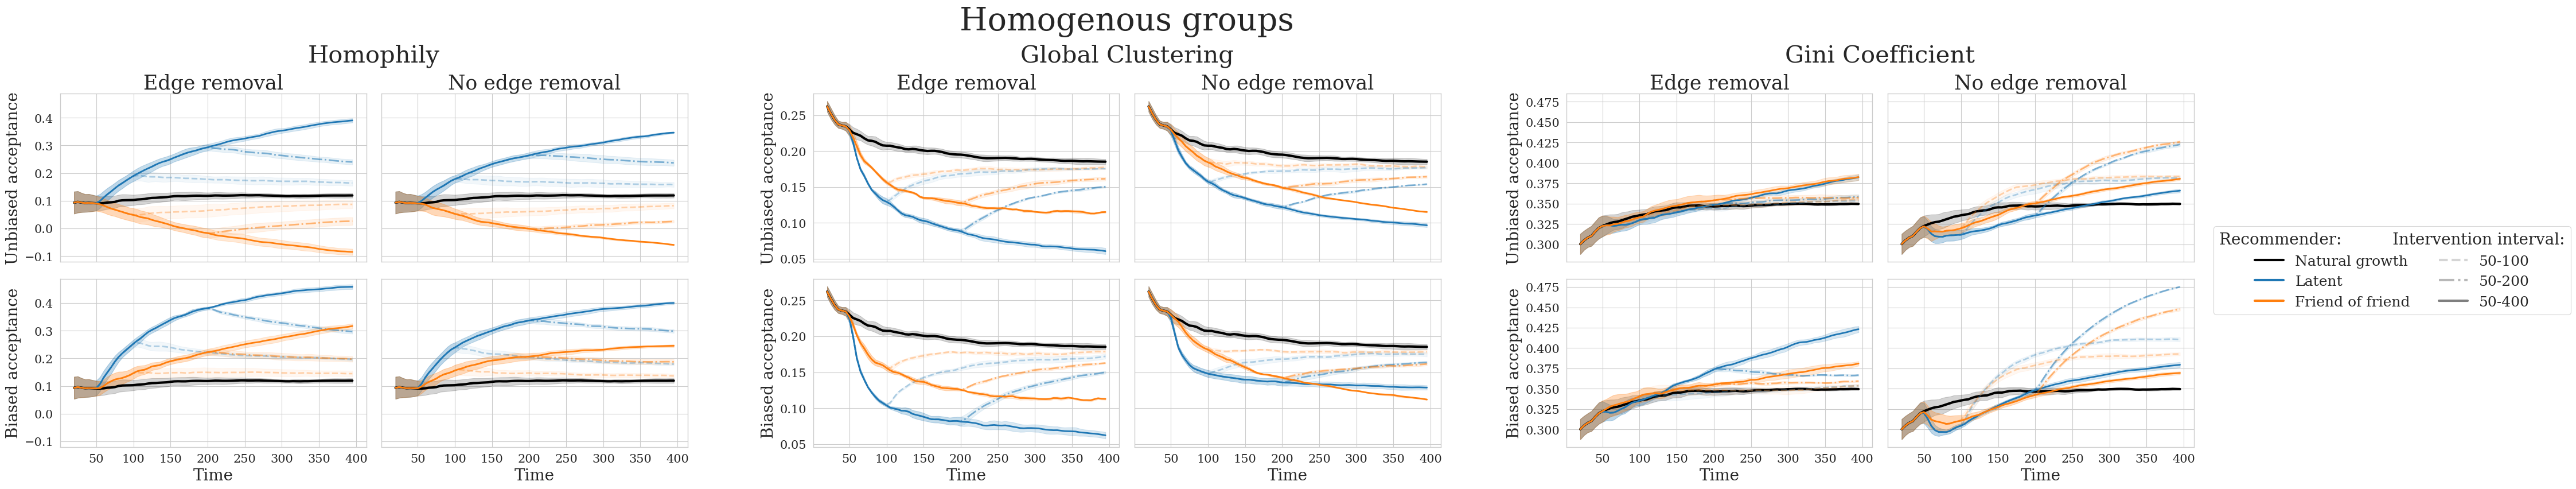

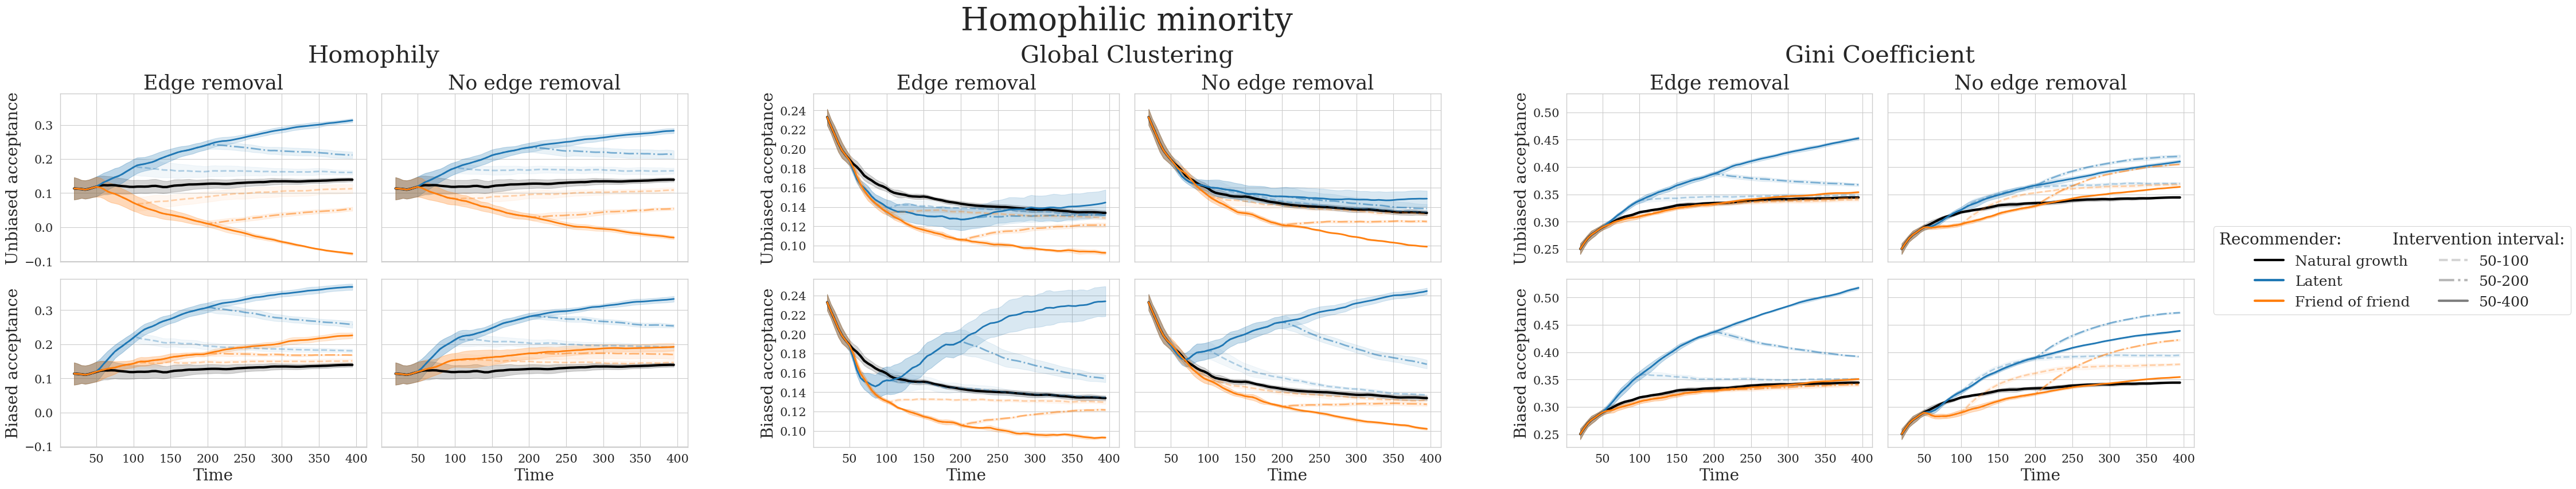

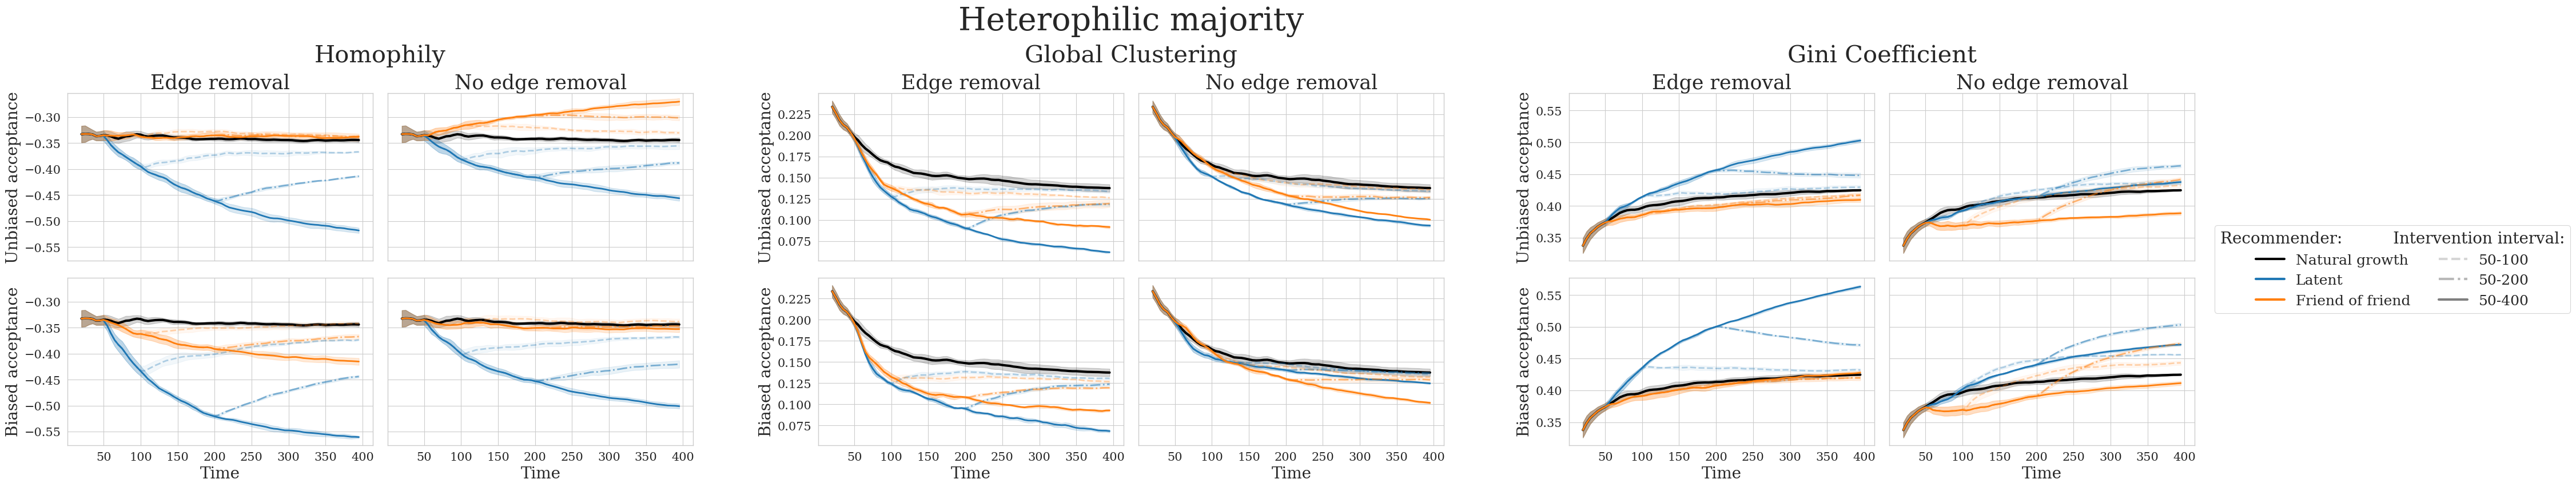

In [92]:
# plot graphs for delayed effects
settings = {'baseline': 'Baseline groups', 
            'heterogeneity': 'Heterogenous groups', 
            'homogeneity': 'Homogenous groups', 
            'minority_homophily': 'Homophilic minority', 
            'majority_heterophily': 'Heterophilic majority'}       
rec_how  = ['embedding', 'random_fof']
node_removal = False
p2_mediated = True
# behavioral settings
acc_how = ['constant', 'embedding']
edge_removal = [True, False]
intervention_end = [50, 100, 200, 300, 400]

with context:
    metrics = {'homophily_0':'Homophily', 'global_clustering':'Global Clustering', 'gini_coeff':'Gini Coefficient'}
    for setting, setting_name in settings.items():
        fig, main_ax = plt.subplots(figsize=(48, 8))
        main_ax.axis('off')
        main_ax.set_title(setting_name, fontsize=40, pad=80)
        outer = gridspec.GridSpec(1, len(metrics), wspace=0.2, hspace=0.2)
        # remove the underlying axes
        for i, (metric, name) in enumerate(metrics.items()): 
            outer_ax = plt.Subplot(fig, outer[i])
            outer_ax.set_title(name, fontsize=30, pad=40)
            fig.add_subplot(outer_ax)  
            outer_ax.axis('off')         
            inner = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=outer[i], wspace=0.05, hspace=0.1)
            ax_list = []
            for j, (acc, edge) in enumerate(product(acc_how, edge_removal)):
                ax = plt.Subplot(fig, inner[j])
                conclusions = longitudinal_exp[(setting, rec_how[0], acc, node_removal, edge, p2_mediated)]
                plot_conclusion(conclusions, metric, ax=ax, pretty_name='', plot_time=[50, 100, 200, 400], add_ci=True)
                conclusions = longitudinal_exp[(setting, rec_how[1], acc, node_removal, edge, p2_mediated)]
                plot_conclusion(conclusions, metric, ax=ax, pretty_name='', plot_time=[50, 100, 200, 400],
                                plot_ng=False, plot_color='tab:orange', add_ci=True)
                fig.add_subplot(ax)
                ax_list.append(ax)
                if j in [0, 1]:
                    ax.set_xticklabels([])
                    ax.set_xlabel('')
                    title = 'Edge removal' if edge else 'No edge removal'
                    ax.set_title(title)
                if j in [1, 3]:
                    ax.set_yticklabels([])
                    ax.set_ylabel('')
                if j in [0, 2]:
                    title = 'Unbiased acceptance' if acc == 'constant' else 'Biased acceptance'
                    ax.set_ylabel(title)
            # determine the xy-axis range
            min_y = min([min(ax.get_ylim()) for ax in ax_list])
            max_y = max([max(ax.get_ylim()) for ax in ax_list])
            # set the same range for all subplots
            [ax.set_ylim([min_y, max_y]) for ax in ax_list]
        
        lines = [Line2D([0], [0], color='black', linewidth=3)]
        lines.extend([Line2D([0], [0], color=c, linewidth=3) for c in ['tab:blue', 'tab:orange']])
        labels = ['Natural growth', 'Latent', 'Friend of friend']
        plot_time = [100, 200, 400]
        alpha = [0.1 + 0.9 * time_range0/400 for time_range0 in plot_time]
        ls = ['--', '-.', '-']
        lines.extend([Line2D([0], [0], color='tab:gray', linewidth=3, alpha=a, linestyle=ls[idx]) for idx, a in enumerate(alpha)])
        labels.extend([f'50-{time_range0}' for time_range0 in plot_time])
        # make an outer legend
        main_ax.legend(lines, labels, loc='center right', bbox_to_anchor=(1.18, 0.5), ncol=2, title='Recommender:          Intervention interval:')
        save_fig(fig, f'longitudinal_{setting}.pdf')
        